In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

import re

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

#from skmultiflow.drift_detection.adwin import ADWIN

from matplotlib import gridspec

from river import drift
from river import metrics
from river.drift import ADWIN

from xgboost import XGBClassifier

In [27]:
data = pd.read_csv(r"C:\Users\sidaj\OneDrive\Desktop\DS440\electricity.csv")
data['class'] = data['class'].astype(pd.StringDtype())
data['class'] = data['class'].str.replace("b'UP'", '1')
data['class'] = data['class'].str.replace("b'DOWN'", '0')
data['class'] = data['class'].astype(int)
data.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,b'2',0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,1
1,0.0,b'2',0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,1
2,0.0,b'2',0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,1
3,0.0,b'2',0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,1
4,0.0,b'2',0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,0


In [28]:
data.shape

(45312, 9)

In [29]:
original_train = data.head(5000) # using 5000 rows for orginal training of model
test_data = data.tail(45312) # rest of the data will be the "new" incoming data we test on
original_train.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,b'2',0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,1
1,0.0,b'2',0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,1
2,0.0,b'2',0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,1
3,0.0,b'2',0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,1
4,0.0,b'2',0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,0


In [30]:
#X = data[['nswprice', 'nswdemand', 'vicprice', 'vicdemand']].values
#y = data['class'].values
#X_train, X_test, y_train, y_test = X[:5000], X[5000:], y[:5000], y[5000:]


#xgbclass = XGBClassifier()
#adwin = ADWIN()

#f1_scores = []
#drift_spots = []

#for i, (x, y_true) in enumerate(zip(X_test, y_test)):
#    if i < 5000:
#        if X_train.shape[0] > 0:
#            xgbclass.fit(X_train, y_train)

#    else:
#        y_pred = xgbclass.predict(x.reshape(1, -1))[0]
#        adwin.update(int(y_pred == y_true))

#        if i % 50 == 0:
#            y_pred_history = xgbclass.predict(X_test[:i+1]).reshape(-1, 1)
#            f1_scores.append(f1_score(y_test[:i+1], y_pred_history))

#        if adwin.drift_detected:
#            drift_spots.append(i)
#            xgbclass = XGBClassifier()
#            xgbclass.fit(X[i-5000:i], y[i-5000:i])
#            adwin = ADWIN()



In [31]:
from sklearn.metrics import f1_score as sk_f1_score

X = data[['nswprice', 'nswdemand', 'vicprice', 'vicdemand']].values
y = data['class'].values
X_train, X_test, y_train, y_test = X[:5000], X[5000:], y[:5000], y[5000:]

xgb = XGBClassifier()
adwin = ADWIN(delta=0.002)

def f1_score(y_true, y_pred):
    return sk_f1_score(y_true, y_pred, average='macro')

f1_scores = []
drift_spots = []

for i, (x, y_true) in enumerate(zip(X_test, y_test)):
    if i < 5000:
        if i % 50 == 0:
            if X_train.shape[0] > 0:
                xgb.fit(X_train, y_train)
            
    else:
        y_pred = xgb.predict(x.reshape(1, -1))[0]
        adwin.update(int(y_pred == y_true))

        if i % 50 == 0:
            y_pred_history = xgb.predict(X_test[:i+1]).reshape(-1, 1)
            f1_scores.append(f1_score(y_test[:i+1], y_pred_history))

        if adwin.drift_detected:
            drift_spots.append(i)
            xgb = XGBClassifier()
            xgb.fit(X[i-5000:i], y[i-5000:i])
            adwin = ADWIN()

In [32]:
#print(f1_scores)
print(len(drift_spots))

50


In [33]:
drift_diff = [x - drift_spots[i - 1] for i, x in enumerate(drift_spots)][1:]
print(drift_spots)

[5191, 6663, 7623, 9127, 10087, 10695, 11207, 12039, 12199, 12455, 13991, 14183, 14759, 14919, 15143, 15367, 15559, 16039, 16647, 17511, 17639, 18279, 18535, 18727, 18951, 19143, 19783, 20199, 21031, 21479, 22023, 23111, 23815, 24615, 24903, 27015, 27495, 29799, 30951, 31335, 31719, 32615, 33319, 34535, 35303, 36039, 36967, 38791, 39271, 40007]


In [34]:
cleaned_spots = [(x - 5000)/50 for x in drift_spots]

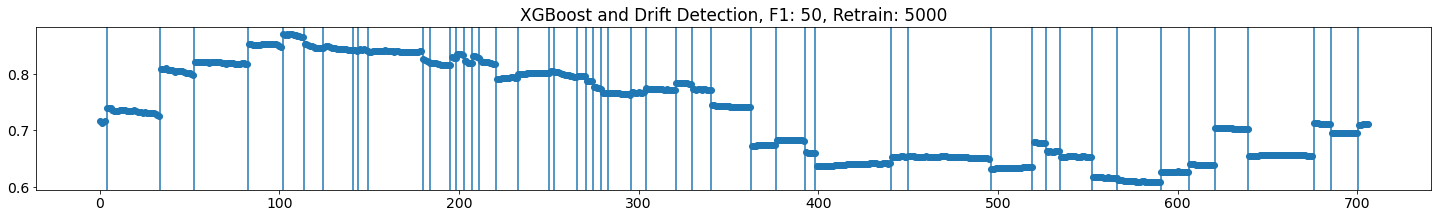

In [35]:
#fig = plt.figure(figsize=(9,3), tight_layout=True)
f1_array = np.array(f1_scores)
xs = [x for x in range(len(f1_scores))]
plt.rcParams['figure.figsize'] = [25,3]
for i in cleaned_spots:
    plt.axvline(x=i)
plt.scatter(xs, f1_array)
plt.title("XGBoost and Drift Detection, F1: 50, Retrain: 5000")
plt.show()

In [36]:
print("average f1 score: " + str(sum(f1_scores)/len(f1_scores)))

average f1 score: 0.7298318028532049


In [37]:
from sklearn.metrics import f1_score as sk_f1_score

X = data[['nswprice', 'nswdemand', 'vicprice', 'vicdemand']].values
y = data['class'].values
X_train, X_test, y_train, y_test = X[:5000], X[5000:], y[:5000], y[5000:]

xgb = XGBClassifier()

def f1_score_2(y_true, y_pred):
    return sk_f1_score(y_true, y_pred, average='macro')

f1_scores_2 = []
drift_spots = []

for i, (x, y_true) in enumerate(zip(X_test, y_test)):
    if i < 5000:
        if i % 50 == 0:
            if X_train.shape[0] > 0:
                xgb.fit(X_train, y_train)
            
    else:
        y_pred = xgb.predict(x.reshape(1, -1))[0]

        if i % 50 == 0:
            y_pred_history = xgb.predict(X_test[:i+1]).reshape(-1, 1)
            f1_scores_2.append(f1_score(y_test[:i+1], y_pred_history))

print(f1_scores_2)

[0.7159792860059329, 0.7128363577661613, 0.7146363241109112, 0.7155958753903908, 0.7168467054254302, 0.7174826675724888, 0.7176758563951109, 0.7144718432651141, 0.7125350919302658, 0.7125894688265182, 0.7125587199218564, 0.7139541492989768, 0.7142180497714059, 0.7125837230803312, 0.710983142483481, 0.7100648343248283, 0.7093817037879873, 0.7090497719126392, 0.7092928586837476, 0.7090200489657055, 0.7075363204564438, 0.705436415346276, 0.705648586732202, 0.7041304039551126, 0.7019750786933268, 0.7026793187478189, 0.6997041299806213, 0.6977387178345138, 0.6970873090801231, 0.6951516891471312, 0.6942394243007188, 0.6924449333842595, 0.690490216895923, 0.6882914571948833, 0.6852398538884567, 0.6851390848664878, 0.685538025513059, 0.6866365806105477, 0.6840000586829154, 0.6850047188221202, 0.6845386262618992, 0.6829480681424269, 0.6844831533147699, 0.6853316791839782, 0.6843926163790335, 0.6849056574801456, 0.6844134006508695, 0.6833723490844299, 0.6826956447801913, 0.6831594994699313, 0.68

In [38]:
print("average f1 score: " + str(sum(f1_scores_2)/len(f1_scores_2)))

average f1 score: 0.6628706638669151


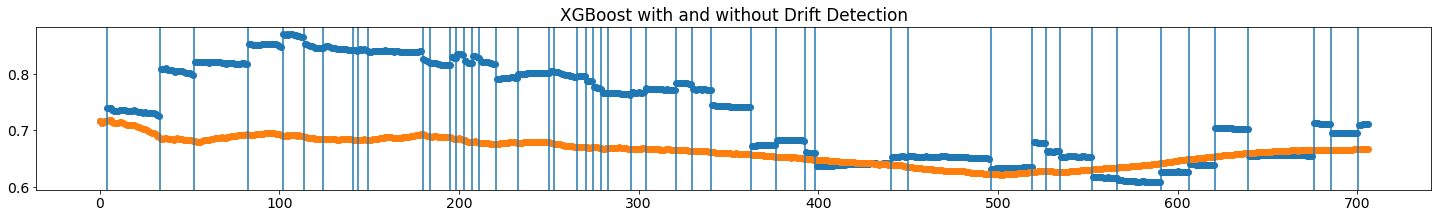

In [39]:
f1_array = np.array(f1_scores)
f1_2_array = np.array(f1_scores_2)
xs = [x for x in range(len(f1_scores))]
plt.rcParams['figure.figsize'] = [25,3]
for i in cleaned_spots:
    plt.axvline(x=i)
plt.scatter(xs, f1_array)
plt.scatter(xs, f1_2_array)
plt.title("XGBoost with and without Drift Detection")
plt.show()


In [42]:
from sklearn.metrics import f1_score as sk_f1_score

X = data[['nswprice', 'nswdemand', 'vicprice', 'vicdemand']].values
y = data['class'].values
X_train, X_test, y_train, y_test = X[:2500], X[2500:], y[:2500], y[2500:]

xgb = XGBClassifier()
adwin = ADWIN(delta=0.002)

def f1_score_3(y_true, y_pred):
    return sk_f1_score(y_true, y_pred, average='macro')

f1_scores_3 = []
drift_spots_2 = []

for i, (x, y_true) in enumerate(zip(X_test, y_test)):
    if i < 2500:
        #if i % 50 == 0:
            if X_train.shape[0] > 0:
                xgb.fit(X_train, y_train)
            
    else:
        y_pred = xgb.predict(x.reshape(1, -1))[0]
        adwin.update(int(y_pred == y_true))

        if i % 50 == 0:
            y_pred_history = xgb.predict(X_test[:i+1]).reshape(-1, 1)
            f1_scores.append(f1_score(y_test[:i+1], y_pred_history))

        if adwin.drift_detected:
            drift_spots_2.append(i)
            xgb = XGBClassifier()
            xgb.fit(X[i-2500:i], y[i-2500:i])
            adwin = ADWIN()

print(f1_scores_3)

[]
